In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import speech_recognition as sr
from langdetect import detect
import matplotlib.pyplot as plt
from googletrans import Translator
from pydub import AudioSegment
import pickle
import re
from IPython.display import Video, display

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Input, Dropout, Dot, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Scikit-learn imports for data splitting and k-fold validation
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress most of the TF warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Suppress TF v1.x warnings


In [2]:
%run predicting_VGG16.ipynb
%run predicting.ipynb
%run training_VGG16.ipynb
%run training.ipynb

In [3]:
def map_to_emotion(label):
    emotion_map = {
        'an': 'Angry',
        'di': 'Disgust',
        'fe': 'Fear',
        'ha': 'Happy',
        'sa': 'Sad',
        'su': 'Surprise'
    }
    # Extract the base emotion from the label (e.g., "an" from "an1")
    base_emotion = label[:2]
    return emotion_map.get(base_emotion, label)

In [4]:
def handle_training(emotion_to_int, emotion_labels):
     # Brief explanation of the approaches
    print("\nBefore we proceed, let's understand the three training approaches available in EmotionNet:")
    print("\n1) Fine-Tuning Approach:")
    print("   - Uses a pre-trained CNN model with an LSTM layer on top.")
    print("   - Leverages the CNN's feature extraction and LSTM's sequence modeling.")
    print("   - Challenges: Slow training and potential overfitting.")
    
    print("\n2) Feature Extraction Approach:")
    print("   - Uses the CNN as a feature extractor for each frame.")
    print("   - The extracted features are passed as a sequence to an LSTM.")
    print("   - Challenges: Results might not be optimal due to feature representation.")
    
    print("\n3) Hybrid Approach:")
    print("   - Combines the above two approaches.")
    print("   - Fine-tunes the top layers of the CNN for better feature extraction.")
    print("   - Extracted features are then used as input to the LSTM.")
    print("   - Aims to balance between pre-trained features and task-specific fine-tuning.")
    
    # Ask the user to choose an approach
    while True:
        approach = input("\nPlease choose a training approach (1/2/3): ")
        # Handle the user's choice
        if approach == "1" or approach == "2":
            print("\nSorry, due to system specifications, we cannot run the chosen model at this time.")
            print("Please consider using the Hybrid Approach (choice 3) for optimal results.")
        elif approach == "3":
            print("\nYou've chosen the Hybrid Approach. Let's proceed with this method!")
            break  # Exit the loop and proceed with the rest of the code for the Hybrid Approach
        else:
            print("Invalid choice. Please enter 1, 2, or 3.")

            
    # Inform the user about the naming convention
    print("\nPlease ensure that the training clips are named according to the following convention:")
    print("The first two letters of each clip's name should represent the emotion attributed to the clip.")
    print(" 'an': 'anger',")
    print(" 'di': 'disgust',")
    print(" 'fe': 'fear',")
    print(" 'ha': 'happiness',")
    print(" 'sa': 'sadness',")
    print(" 'su': 'surprise'\n")
    
    # Get the path to the training clips folder
    folder_path = input("Enter the path to the folder containing the training clips: ")

    # Ask the user to choose between a custom CNN or VGG16
    while True:
        print("\nChoose the CNN model you'd like to use:")
        print("1. Custom pre-trained CNN")
        print("2. VGG16")
        cnn_choice = input("Enter your choice (1 or 2): ")

        if cnn_choice == "1":
            custom_cnn_path = input("Enter the path to your custom pre-trained CNN model: ")
            print("You chose a custom model with path:", custom_cnn_path)
            break
        elif cnn_choice == "2":
            custom_cnn_path = None  # This will indicate that we're using VGG16
            print("You chose VGG16.")
            break
        else:
            print("Invalid choice. Please enter '1' or '2'.")
            
            
    # Display the summary
    print(f"\n    Summary of provided data:")
    print(f"\t    Chosen approach: {approach}")
    print(f"\t    Chosen Pre-trained CNN: {cnn_choice}")
    print(f"\t    Training clips folder: {folder_path}")
    
    # Ask the user to proceed or reset
    while True:
        decision = input("    Do you want to proceed with the above data? (yes to proceed / no to reset and start again): ").lower()
        if decision == "yes":
            print('\n')
            print("*" *25, "TRAINING", "*" *25,"\n1) We are going to extract still frames from the clips...")
            extract_frames_from_folder(folder_path)
             # Adjust the feature extraction and LSTM training based on the chosen CNN
            if custom_cnn_path:
                print("\n\n2) We are going to extract features from the frames of the clips with your custom pre-trained CNN model...")
                sequences, y_train_labels = prepare_data_from_frames_custom(folder_path, emotion_to_int, emotion_labels, custom_cnn_path)
                print("\n\n3) We are going to input the features in an LSTM model after preprocessing...")
                run_lstm(sequences, y_train_labels, emotion_labels)
                
            else:
                print("\n\n2) We are going to extract features from the frames of the clips with the VGG16 model...")
                sequences, y_train_labels = prepare_data_from_frames_VGG16(folder_path, emotion_to_int, emotion_labels)
                print("\n\n3) We are going to input the features in an LSTM model after preprocessing...")
                run_lstm_VGG16(sequences, y_train_labels, emotion_labels)
            break
        elif decision == "no":
            print("\n...resetting data...\n")
            handle_training(emotion_to_int, emotion_labels)  # Recursively call the function to start again
            break
        else:
            print("Invalid input. Please enter 'yes' or 'no'.")
    return sequences, y_train_labels, custom_cnn_path


In [5]:
def handling_predicting(emotion_to_int, emotion_labels, custom_cnn_path):
    # Get the path to the training clips folder
    clip_path = input("\n    Enter the path to the clip: ")
    
    # Get the language
    # language = input("Enter the language: ")
    speech_recognition_lang, translation_lang = get_language_choice()
    
    # Display the summary
    print(f"\n    Summary of provided data:")
    print(f"\t\tClip to predict: {clip_path}")
    print(f"\t\tLanguage: {speech_recognition_lang}\n")
    
    # Ask the user to proceed or reset
    while True:
        decision = input("    Do you want to proceed with the above data? (yes to proceed / no to reset and start again): ").lower()
        if decision == "yes":
            print('\n')
            print("*" *25, "PREDICTING", "*" *25,"\n1) We are going to extract still frames from the clip...")
            if custom_cnn_path:
                frames = preprocess_video_clip(clip_path)
            else: 
                frames = preprocess_video_clip_VGG16(clip_path)
            print("\n\n2) We are going to extract features from the frames of the clips with our pre-trained CNN model...")
            if custom_cnn_path:
                clip_features = prepare_single_clip_data(frames)
            else:
                clip_features = prepare_single_clip_data_VGG16(frames)
            print("\n\n3) We are going to create the text from the audio...")
            en_text = process_audio_from_video(clip_path, speech_recognition_lang, translation_lang)
            print("\n\n4) We are going to preprocess the text...")
            tokenized_padded_text = preprocess_text(en_text)
            print("\n\n5) We are going feed the audio and video in the Multi-imput LSTM model for prediction")
            if custom_cnn_path:
                run_multi_input(clip_features, tokenized_padded_text, emotion_labels)
            else:
                run_multi_input_VGG16(clip_features, tokenized_padded_text, emotion_labels)
           

            break
        elif decision == "no":
            print("\n...resetting data...\n")
            handling_predicting(emotion_to_int, emotion_labels)  # Recursively call the function to start again
            break
        else:
            print("Invalid input. Please enter 'yes' or 'no'.")

In [6]:
def get_language_choice():
    # Dictionary mapping user-friendly language names to their codes for Google Speech Recognition and Translation
    language_map = {
        "English": ("en-US", "en"),
        "Italian": ("it-IT", "it"),
        "Spanish": ("es-ES", "es"),
        "French": ("fr-FR", "fr"),
        # ... add more languages as needed
    }

    # Display the language menu
    print("\n   Please insert the language of the video clip:")
    for idx, lang in enumerate(language_map.keys(), 1):
        print(f"\t{idx}) {lang}")

    # Get the user's choice
    while True:
        choice = input("\n    Enter your choice (number): ")
        try:
            selected_language = list(language_map.keys())[int(choice) - 1]
            return language_map[selected_language]
        except (ValueError, IndexError):
            print("Invalid choice. Please enter a number from the list.")

In [7]:
def get_user_input(emotion_to_int, emotion_labels):
    print('*'*27)
    print("*  WELCOME TO EMOTIONNET  *")
    print('*'*27)
    
    print("\nEmotionNet is a specialized tool designed to analyze and understand individual-specific emotional expressions from video clips.")
    print("Using a combination of Convolutional Neural Networks (CNN) and Long Short-Term Memory (LSTM) networks, EmotionNet:")
    print("    1. Learns facial expressions from video clips of a single individual.")
    print("    2. Assesses the emotional congruence between the individual's facial expressions and spoken words.")
    print("This tool can be invaluable for media performers during rehearsals, ensuring their facial expressions align with their spoken words.")
    print("Additionally, EmotionNet's unique approach holds potential as a component in advanced lie detection systems.\n")
    
    
    while True:  # This loop will keep running until the user decides to exit
        print("\n    Please choose an action:")
        print("\t1) Train a new RNN")
        print("\t2) Analyze a video clip (requires a trained RNN)")
        print("\t3) Exit")

        choice = input("\n    Enter your choice (1, 2, or 3): ")

        if choice == "1":
            sequences, y_train_labels, custom_cnn_path = handle_training(emotion_to_int, emotion_labels)
            print("\nTraining successfully completed! The trained RNN model is now: 'Models/best_rnn_model.h5'")
        elif choice == "2":
            while True:  # Keep asking until valid input is provided
                confirmation = input("    To proceed with this action, you must have an RNN trained on the same individual you intend to analyze saved in the folder 'Models'.\n    Can you confirm? (yes/no): ")
                if confirmation.lower() == "yes":
                    print("    You chose to analyze a video clip.")
                    handling_predicting(emotion_to_int, emotion_labels, custom_cnn_path)
                    break  # Exit the inner loop after analyzing the video clip
                elif confirmation.lower() == "no":
                    break  # Exit the inner loop without analyzing the video clip
                else:
                    print("Invalid input. Please enter 'yes' or 'no'.")
        elif choice == "3":
            print("\n")
            print('*'*32)
            print("* Exiting EmotionNet. Goodbye! *")
            print('*'*32)
            break  # This will break out of the while loop and end the function
        else:
            print("    Invalid choice. Please enter 1, 2, or 3.")


***************************
*  WELCOME TO EMOTIONNET  *
***************************

EmotionNet is a specialized tool designed to analyze and understand individual-specific emotional expressions from video clips.
Using a combination of Convolutional Neural Networks (CNN) and Long Short-Term Memory (LSTM) networks, EmotionNet:
    1. Learns facial expressions from video clips of a single individual.
    2. Assesses the emotional congruence between the individual's facial expressions and spoken words.
This tool can be invaluable for media performers during rehearsals, ensuring their facial expressions align with their spoken words.
Additionally, EmotionNet's unique approach holds potential as a component in advanced lie detection systems.


    Please choose an action:
	1) Train a new RNN
	2) Analyze a video clip (requires a trained RNN)
	3) Exit



    Enter your choice (1, 2, or 3):  1



Before we proceed, let's understand the three training approaches available in EmotionNet:

1) Fine-Tuning Approach:
   - Uses a pre-trained CNN model with an LSTM layer on top.
   - Leverages the CNN's feature extraction and LSTM's sequence modeling.
   - Challenges: Slow training and potential overfitting.

2) Feature Extraction Approach:
   - Uses the CNN as a feature extractor for each frame.
   - The extracted features are passed as a sequence to an LSTM.
   - Challenges: Results might not be optimal due to feature representation.

3) Hybrid Approach:
   - Combines the above two approaches.
   - Fine-tunes the top layers of the CNN for better feature extraction.
   - Extracted features are then used as input to the LSTM.
   - Aims to balance between pre-trained features and task-specific fine-tuning.



Please choose a training approach (1/2/3):  3



You've chosen the Hybrid Approach. Let's proceed with this method!

Please ensure that the training clips are named according to the following convention:
The first two letters of each clip's name should represent the emotion attributed to the clip.
 'an': 'anger',
 'di': 'disgust',
 'fe': 'fear',
 'ha': 'happiness',
 'sa': 'sadness',
 'su': 'surprise'



Enter the path to the folder containing the training clips:  Training_Clips



Choose the CNN model you'd like to use:
1. Custom pre-trained CNN
2. VGG16


Enter your choice (1 or 2):  2


You chose VGG16.

    Summary of provided data:
	    Chosen approach: 3
	    Chosen Pre-trained CNN: 2
	    Training clips folder: Training_Clips


    Do you want to proceed with the above data? (yes to proceed / no to reset and start again):  yes




************************* TRAINING ************************* 
1) We are going to extract still frames from the clips...
	...total clips in the folder: 24
	...creating a new folder to store frames from clips at: Training_Clips\Separated_Frames
	...extracting frame: 178 from clip: 23 of 24  

   SUMMARY: 
	Extracted 4031 frames from the folder 'Training_Clips' and saved in 'Training_Clips\Separated_Frames'
	Total clips extracted: 24
	Example frame name: Training_Clips\Separated_Frames\su5\frame_0000.png


2) We are going to extract features from the frames of the clips with the VGG16 model...
	...loading VGG16 pre-trained model
	...found 24 folders of frames, each from a clip
		...resizing frames...
		...extracting features with the CNN model...
		...creating labels from titles of folders...
		...of file 179/179 in folder 24, called su5  

   SUMMARY: 
	Processed all emotion folders from 'Training_Clips\Separated_Frames'
	    Total folders processed: 24
	    Labels assigned: [0, 0, 1, 


Would you like to verify the inputs before proceeding? (yes/no):  yes



	Choose a method of verification:
	1. Display a summary of the data (shape, data type).
	2. Display the first few rows of the data.
	3. Display random samples from the data.
	4. Display basic statistics for the data.
	5. Proceed without further verification.


Enter your choice (1/2/3/4/5):  1



		Sequences shape: (24, 193, 25088)
		One-hot encoded labels shape: (24, 6)

	Choose a method of verification:
	1. Display a summary of the data (shape, data type).
	2. Display the first few rows of the data.
	3. Display random samples from the data.
	4. Display basic statistics for the data.
	5. Proceed without further verification.


Enter your choice (1/2/3/4/5):  4



		Sequences mean: 0.49148804
		Sequences median: 0.0
		Sequences standard deviation: 4.035366

	Choose a method of verification:
	1. Display a summary of the data (shape, data type).
	2. Display the first few rows of the data.
	3. Display random samples from the data.
	4. Display basic statistics for the data.
	5. Proceed without further verification.


Enter your choice (1/2/3/4/5):  5


	...creating the model


**********************************************************************
Model: "Our_Chosen_RNN_Model_VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 25088)]     0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 25088)       0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               12911104  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 12,911,878
Trainable params: 12,911,878
Non-trainable params: 0
________________________________________________________________


Enter your choice (1/2/3/4/5/6):  1


Validation Accuracy: 100.00%

    Choose an evaluation option:
	1) Evaluate on validation set
	2) Plot training loss vs validation loss graph
	3) Plot training accuracy vs validation accuracy graph
	4) Print confusion matrix
	5) Print classification report
	6) Exit evaluation



Enter your choice (1/2/3/4/5/6):  2


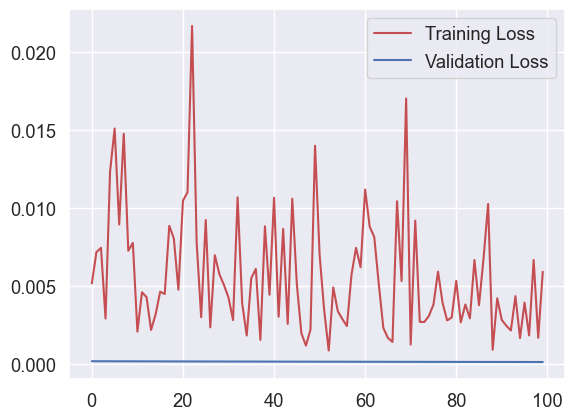


    Choose an evaluation option:
	1) Evaluate on validation set
	2) Plot training loss vs validation loss graph
	3) Plot training accuracy vs validation accuracy graph
	4) Print confusion matrix
	5) Print classification report
	6) Exit evaluation



Enter your choice (1/2/3/4/5/6):  3


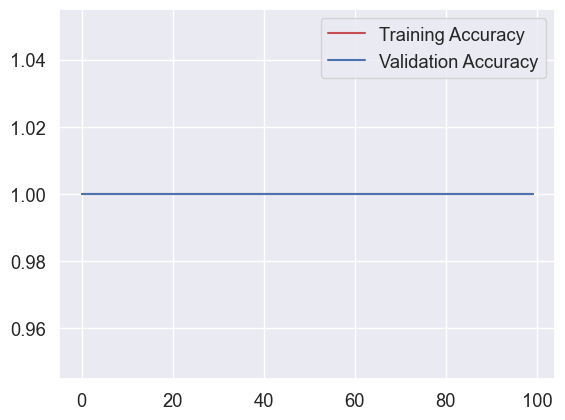


    Choose an evaluation option:
	1) Evaluate on validation set
	2) Plot training loss vs validation loss graph
	3) Plot training accuracy vs validation accuracy graph
	4) Print confusion matrix
	5) Print classification report
	6) Exit evaluation



Enter your choice (1/2/3/4/5/6):  4


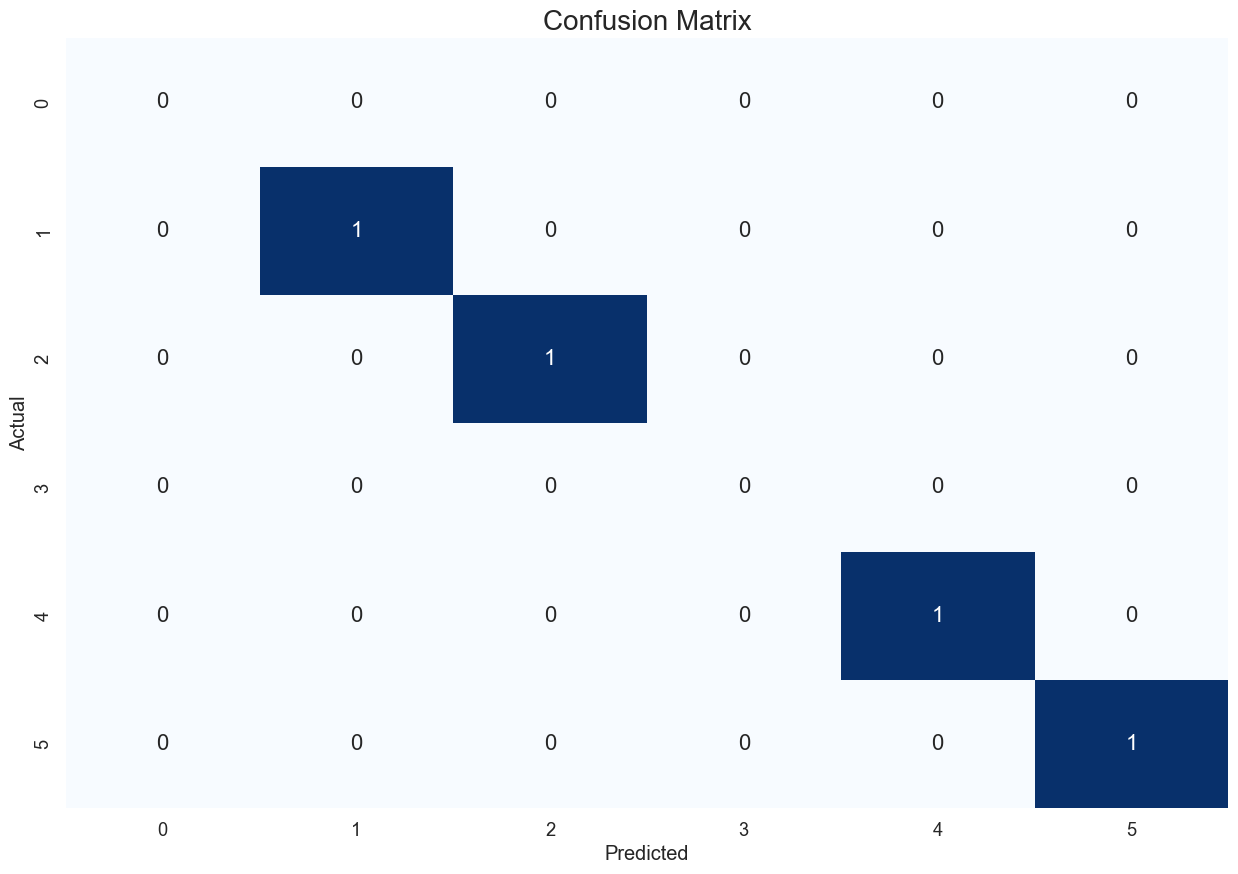


    Choose an evaluation option:
	1) Evaluate on validation set
	2) Plot training loss vs validation loss graph
	3) Plot training accuracy vs validation accuracy graph
	4) Print confusion matrix
	5) Print classification report
	6) Exit evaluation



Enter your choice (1/2/3/4/5/6):  5


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4


    Choose an evaluation option:
	1) Evaluate on validation set
	2) Plot training loss vs validation loss graph
	3) Plot training accuracy vs validation accuracy graph
	4) Print confusion matrix
	5) Print classification report
	6) Exit evaluation



Enter your choice (1/2/3/4/5/6):  6



Training successfully completed! The trained RNN model is now: 'Models/best_rnn_model.h5'

    Please choose an action:
	1) Train a new RNN
	2) Analyze a video clip (requires a trained RNN)
	3) Exit



    Enter your choice (1, 2, or 3):  2
    To proceed with this action, you must have an RNN trained on the same individual you intend to analyze saved in the folder 'Models'.
    Can you confirm? (yes/no):  yes


    You chose to analyze a video clip.



    Enter the path to the clip:  an1.avi



   Please insert the language of the video clip:
	1) English
	2) Italian
	3) Spanish
	4) French



    Enter your choice (number):  2



    Summary of provided data:
		Clip to predict: an1.avi
		Language: it-IT



    Do you want to proceed with the above data? (yes to proceed / no to reset and start again):  yes




************************* PREDICTING ************************* 
1) We are going to extract still frames from the clip...
	...extracting and resizing frame: 168 of 168 frames


   SUMMARY: 
	The clip an1.avi has been transformed in frames with the right format
	    Total frames created: 168
	    Frame format: 'size=224x224', 'color=RGB'


2) We are going to extract features from the frames of the clips with our pre-trained CNN model...
	...loading the VGG16 pre-trained model
	...resizing, converting to RGB, normalising and extracting features from frame: 168 of 168 


   SUMMARY: 
	The 168 frames have been transformed into a vector of features through the VGG16 model
	    Total vectors created: '1'
	    Total frames: '168'
	    Total feature per frame: '25088' (as per VGG16 output)
	    Reality check: 
		'Print shape of resulting array' = (168, 25088)


3) We are going to create the text from the audio...
	...extracting the audio from the video: an1.avi
	...audio saved successfully on


	Do you want to view the video clip for verification? (yes/no):  yes


	...converting in compatible format




	Press Enter once you're done watching the video... 



   SUMMARY: 
	The audio of the clip: an1.avi has been captured and translated
	    Input language: 'it'
	    Translated language: 'en'


4) We are going to preprocess the text...
	...'#' and '@' removed from the text
	...tokenizer: <keras_preprocessing.text.Tokenizer object at 0x000001A208824670> has been loaded
	...the text has been tokenized into sequences
	...the text has been padded with 'PRE' 500 characters

   SUMMARY: 
	The text has been sanitized and preprocessed to meet the model input requirements
	    Tokenizer used: '<keras_preprocessing.text.Tokenizer object at 0x000001A208824670>' (as per trained model)
	    sequences shape '(1, 500)' (as per trained model)
	    sequence example [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 

	Press Enter once you're done checking the model... 



	...importing pre-trained rnn model for text stream input


**********************************************************************
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          5097600   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               330240    
_________________________________________________________________
dense (Dense)                (None, 6)                 1542      
Total params: 5,429,382
Trainable params: 331,782
Non-trainable params: 5,097,600
_________________________________________________________________
********************************************************************** 



	Press Enter once you're done checking the model... 



	...creating our Multi_Input model


**********************************************************************
Model: "Our_MultiInputModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, 25088) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
Our_Chosen_RNN_Model_VGG16 (Fun (None, 6)            12911878    input_4[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 6)            5429382     input

	Press Enter once you're done checking the model... 



	...predicting Similarity
	...evaluating results


**********************************************************************
    Predicted Similarity Score: 0.8007 - Perfect Match
**********************************************************************

    Please choose an action:
	1) Train a new RNN
	2) Analyze a video clip (requires a trained RNN)
	3) Exit



    Enter your choice (1, 2, or 3):  3




********************************
* Exiting EmotionNet. Goodbye! *
********************************


In [13]:
K.clear_session()
emotion_to_int = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5}
emotion_labels= [emotion_to_int[i] for i in sorted(emotion_to_int.keys())]
get_user_input(emotion_to_int, emotion_labels)